## Support Vector Machines
* performs linear or nonlinear classification and regression, and even outlier detection
* well suited for complex *small* to *medium* sized datasets

## Linear SVM
* **Maximal margin classifier** - fit a hyperplane such that the hyperplane is farthest from the training observations; this only exists if the data is linearly separable
* **Support vector classifier** (**Linear SVM**) - same as maximal margin classifier, but have a "budget" as to how many instances can violate the margin (i.e. wrong side of hyperplane) or be within the margin boundaries. These instances are known as **support vectors**.

The former is also known as a *hard margin classifier* and the latter is known as a *soft margin classifier*.

The hard margin classifier is sensitive to outliers, so we want to strike a balance with the soft margin classifier between a large margin and the number of support vectors.

In `sklearn`, the hyperparameter `C` controls the flexibility of the SVM. *A small `C` value leads to a wider margin, but more margin violations, that is, the model is more flexibile.* *A large `C` value leads to a narrower margin, and less margin violations, that is, the model is less flexible.*

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2,3)] # petal length, width
y = (iris["target"] == 2).astype(np.float64) # iris-virginica

svm_clf = Pipeline([
    ("scaler", StandardScaler()), # SVMs assume data is normalized
    ("linear_svc", LinearSVC(C=1, loss="hinge"))
])

svm_clf.fit(X,y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [3]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

SVMs do not output probabilities since it is NOT a probabilistic model. [You can estimate the probability.](https://scikit-learn.org/stable/modules/calibration.html)

In `sklearn`, there are three different flavors of the linear SVM:
1. `LinearSVC(loss="hinge")` - default loss is `squared_hinge`
2. `SVC(kernel="linear")` - slowest implementation; usually use this for nonlinear SVM
3. `SGDClassifier(loss="hinge")` - doesn't converge as fast, but it is good for large datasets or online classification tasks

## Nonlinear SVM
* adding polynomial features
* adding similarity features
* polynomial and RBF kernels

#### Polynomial Features
* low polynomial degrees cannot deal with very complex data
* high polymial degrees creates too many features

In [4]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

X, y = make_moons(noise=0.2, random_state=1)

polynomial_svm_clf.fit(X,y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

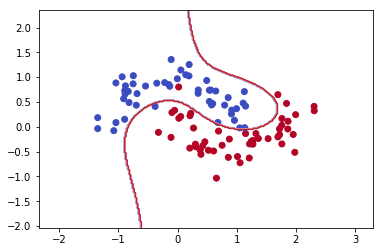

In [5]:
i_min, i_max = X[:,0].min() - 1, X[:,0].max() + 1
j_min, j_max = X[:,1].min() - 1, X[:,1].max() + 1
ii, jj = np.meshgrid(np.arange(i_min, i_max, 0.02),
                     np.arange(j_min, j_max, 0.02))

Z = polynomial_svm_clf.predict(np.c_[ii.ravel(), jj.ravel()])
Z = Z.reshape(ii.shape)
plt.contour(ii,jj, Z, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm)
plt.xlim(ii.min(), ii.max())
plt.ylim(jj.min(), jj.max())
plt.show()

#### Polynomial Kernel
* kernel trick to get results as if you added many polynomial features
* use `SVC` with `kernel="poly"` and `degree=d`
* has hyperparameter `coef0` which is the [indepedent term added](https://scikit-learn.org/stable/modules/svm.html#svm-kernels)

In [18]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=6, coef0=5, C=5))
])

X, y = make_moons(noise=0.5, random_state=1)

poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=5,
  decision_function_shape='ovr', degree=6, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

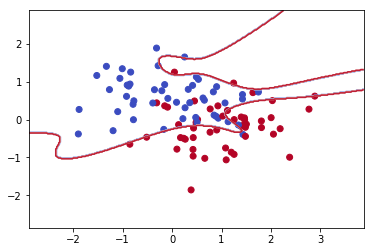

In [19]:
i_min, i_max = X[:,0].min() - 1, X[:,0].max() + 1
j_min, j_max = X[:,1].min() - 1, X[:,1].max() + 1
ii, jj = np.meshgrid(np.arange(i_min, i_max, 0.02),
                     np.arange(j_min, j_max, 0.02))

Z = poly_kernel_svm_clf.predict(np.c_[ii.ravel(), jj.ravel()])
Z = Z.reshape(ii.shape)
plt.contour(ii,jj, Z, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm)
plt.xlim(ii.min(), ii.max())
plt.ylim(jj.min(), jj.max())
plt.show()

#### Similarity Features
* measures how much each instance resembles a particular landmark
* let the similarity function be the *Gaussian Radial Basis Function*

A RBF is a real-valued function $\phi$ whose value depends only on the distance from some other point $c$, so that $\phi(x,c) = \phi(||x-c||)$.

The Gaussian RBF uses the $l^2$ norm.
$$
\phi(x,c) = \exp{(-\gamma||x-c||^2)}
$$
It is a bell-shaped function ranging from 0 (very far away from $c$) to 1 (at the landmark).

**How can this be added as features?** Given $x_1$ and landmarks $c_1, c_2$, we calculate $\phi(x_1, c_1)$ and $\phi(x_1, c_2)$ and set them as features

**How are landmarks selected?** One approach is to make a landmark at the location of each and every instance in the dataset, but this increases the dimensionality of the data

#### Gaussian RBF Kernel